## Below are the functions from the "regular" wikidata/pedia notebook

In [1]:
from qwikidata.sparql import (get_subclasses_of_item, return_sparql_query_results)
import pandas as pd
import import_ipynb

#### Beautiful Soup Scrape for Tables

import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen
import re
import random
import json
import csv

from itertools import chain
import json

import wikipedia

###  FUNCTIONS

#### Wikidata Functions

# Put wikidata results into a dataframe
def noice(results):
    noice = []
    for res in results['results']['bindings']:
        temp={}
        for h in headers:
            if h in res.keys():
                if h == "item":
                    
                    item_url = res[h].get('value', "None")
                    q_code = item_url.split("/")[-1]
                    temp[h] = q_code

                else:
                    temp[h] = res[h].get('value', "None")

        noice.append(temp)
        
    return pd.DataFrame(noice)

# Delete rows without a URL
def delete_no_url(df, NaN_column='article_url'):
    
    df = df.dropna(subset=[NaN_column])
    df = df.reset_index(drop=True, inplace=False)
    
    return df

def collapser1(item, df):
    joiner = ", ".join(list(df[df["item"] == item]["instanceOfLabel"]))
    return joiner

#### Wikipedia Functions

# Used in get_all_wikipedia_urls: scrapes for url 
def lister(soup):
    result = []
    uls = soup.find_all('ul', {'class': 'mw-allpages-chunk'})
    base ="https://en.wikipedia.org"
    for ul in uls:
        for li in ul.find_all('li'):
            for link in li.find_all('a'):
                end_url = link.get('href')
                url = base + end_url
                result.append(url)      
    return result

#Scrape main wikipedia category pages for all the urls on the pages
def get_all_wikipedia_urls(urls):
    res = []
    for url in urls:
        html = urlopen(url)
        soup = BeautifulSoup(html, 'html.parser')

        temp = lister(soup)
        res.append(temp)
        
    res = [i for g in res for i in g]
        
    return res

# tag the wikipedia urls with the instancesOf tags
def url_categories(wikipedia_urls):
    count = 0
    result = []
    tot = len(wikipedia_urls)
    
    print("Starting scrape for wikipedia articles' properties")
    
    for url in wikipedia_urls:
        if count%50 == 0 and count != 0:
            print(f'Scraped {count} of {tot} urls for properties')
            
        response = requests.get(url)
        soup = BeautifulSoup(response.text,"html.parser")

        cup_o_soup = soup.find('div', {'class': 'mw-normal-catlinks'})
        temp = []
        for cup in cup_o_soup.find_all("li"):
            for link in cup.find_all('a'):
                instant_cup = link.get('title').split(":")[-1]
                temp.append(instant_cup)
        result.append((url,temp))
        count += 1

    print("Property scrape complete")
    return result

def display_all_results(super_list_dict):

    df = pd.DataFrame(columns=["number of dataframes", "key", "url"])
    i = 0
    
    for d_ in super_list_dict:
        key = [x for x in d_.keys()][0]
        url = d_.get('url', "None")
        num_df = len(d_[key])
        df.loc[i] = [str(num_df), key, url]
        i += 1
            
    #print(f' num df: {num_df} | key: {key} | url: {url}')

    return df 

#random delay to avoid getting scrape blocked
def decision(probability, maxdelay=8):
    
    if random.random() < probability:
        delay = random.randint(1, maxdelay)
    else:
        delay = 0
    
    return delay

#List of dicts; dict values are of dataframes of the tables for that particular url
def table_scrapes(url_list_full, prob=.10, maxdelay=4):

    headers= {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}
    
    print("Starting your scrape...")

    #Add key to tuple in "amplified" list of urls from wikidata search
    urls_amp = [(x[0], x[0].split("/")[-1], x[1]) for x in url_list_full] 
    
    # initialize
    super_list_dict = []
    count = 0
    success = 0
    tot = len(url_list_full)
    delay = [decision(prob,maxdelay) for x in range(tot)]
    
    # Iterate over each url, pull out any wikitables and throw into super list with key=article url tag
    for url_tup in urls_amp:

        if delay[count] != 0:
            print(f'Pause scrape for {delay[count]} second(s)')
            time.sleep(delay[count])
        
        # unique keys for the url
        url = url_tup[0]
        key = url_tup[1]
        cup = url_tup[2]

        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text,"html.parser")
        
        #soup it 
        tables = soup.find_all("table", {"class":["wikitable", "infobox", "infobox vevent", "infobox vcard"]})
        
        if tables != []:
            try:
                # build temp dicts to dump into temp list that dumps into overall super list 
                df_dict = {}
                temp_list = []

                for table in tables:

                    str_tab = str(table)

                    #one-off replace to fix html error
                    str_tab = str_tab.replace('6;', '6')

                    temp_df = pd.read_html(str_tab)[0]
                    temp_list.append(temp_df)

                df_dict[key] = temp_list
                df_dict["url"] = url
                df_dict["properties"] = cup
                
                # add table df to super list
                super_list_dict.append(df_dict) 
                
                #success counter
                success +=1

            except:
                print(f"Skipping Parsing Error for: {url}")
        else:
            print(f"No wikitables found, skipping: {url}")
        
        #Display
        if count%100 == 0 and count != 0:
            print()
            print(f'**** Scraped {count} of {tot} urls ****')
            print()
        count += 1    
    
    print("!!!! Complete !!!!")       
    print(f'{success} of {tot} urls have wikitables')

    return super_list_dict  



### Search Functions

# Search across all text for keyword
def keyword_search(soup_results, keyword):
    
    search_result = []
    outer_cnt = 0 
    
    for res in soup_results:

        for k,v in res.items():
            if k != "url":
                key=k
            if k == "url":
                url=res[k]

        inner_cnt = 0
        for frame in res[key]:

            t=frame.to_dict()
            values = set(chain.from_iterable(i.values() for i in t.values()))
            values = (str(values).split())

            temp_result = []
            for elem in values:
                if keyword.lower() in elem.lower():

                    temp_result = [outer_cnt, inner_cnt, key, url]

            if temp_result != []:
                search_result.append(temp_result)

            inner_cnt += 1    
        outer_cnt += 1
        
    for line in search_result:
        print(line)
    
    if search_result == []:
        return print("No results found")
        
    return search_result

# IN PROGRESS...
def search_title1(keyword, df):
    
    print(df[df['key'].str.contains(keyword, case=False)])      

# IN PROGRESS...
def search_title2(keyword, url_list):
    
    search_words = [x.split("/")[-1].lower() for x in url_list]

    index = []
    for words in search_word:
        temp_index = []
        if keyword.lower() in words:
            ind = search_words.index(words)
            index.append(ind)
            
    return index

# Here's where we start the HYDRO USE-CASE

In [2]:
#pip install Shapely
#pip install geopandas
#pip install descartes
#pip install geoplot
#pip install contextily

import itertools
import contextily as ctx
import shapely
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
import geopandas as gpd

## Framing the analysis:

### Can wikipedia tables enable meaningful analysis of electrical power production in Oromia Region of Ethiopia? 

### Questions:
 1. Can we geolocate the hydroelectric plants?
 2. Can we extract the total power production?

### ...and if there was a major event in Oromia affecting power production...

 3. What percentage of Ethiopia’s power would be at risk?
 4. Which specific facilities would be at risk?
 5. Can we extract power output for potentially affected plants, and compare that with overall power production?

 
Notes:

Without a reservoir, flooding of the upper part of the river does not take place. As a result, people remain living at or near the river and existing habitats are not flooded. Any pre-existing pattern of flooding will continue unaltered, which presents a flood risk to the facility and downstream areas.
    
    "Unfirm" power
Run-of-the-River power is considered an "unfirm" source of power: a run-of-the-river project has little or no capacity for energy storage[12] and so cannot co-ordinate the output of electricity generation to match consumer demand. It thus generates much more power when seasonal river flows are high (ispring freshet),[13] and depending on location, much less during drier summer months or frozen winter months.

Oromia shapefile: https://www.arcgis.com/home/item.html?id=0684b2e8386248c486c6d5e430b25559

### Step 1: Get Wikipedia article of interest:
1. Scrape categories
2. Scrape Tables
3. Return dataframe with all Tables and tagged with article's properties

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_power_stations_in_Ethiopia'
categories = url_categories([url])
hydro_scrape = table_scrapes(categories, prob=.10)

Starting scrape for wikipedia articles' properties
Property scrape complete
Starting your scrape...
Pause scrape for 4 second(s)
!!!! Complete !!!!
1 of 1 urls have wikitables


### Step 2: Clean the data

In [4]:
# grab first table with list of hydro power plants
hydro_list = hydro_scrape[0]['List_of_power_stations_in_Ethiopia'][0]

#Delete NaN Rows (Rows with Totals)
hydro_list = hydro_list[hydro_list['ICS Power plant'] != 'Total']
hydro_list = hydro_list[hydro_list['ICS Power plant'] != 'Total operational']

# Rename laborious column header
hydro_list = hydro_list.rename(columns={'Capacity factor(2016/17)[6][7][8][9][3]': 'Capacity Factor'})

# Get series of lat/long strings
hydro_coords_s = hydro_list['Coordinates']
lat_= []
lon_ = []

#Convert Coordinates to float-type lat/long for plotting and subsetting to Oromia Region
for str_coord in hydro_coords_s:
    #if type(str_coord) == str:
    temp = str_coord.split("/")[1]
    lat = float(temp.split(" ")[1].split("°")[0].split("\ufeff")[1])
    lon = float(temp.split(" ")[2].split("°")[0])
    lat_.append(lat)
    lon_.append(lon)
    
# Add lat/long series to dataframe
hydro_list.insert(2, "Latitude", lat_)
hydro_list.insert(3, "Longitude", lon_)
hydro_list.head(3)  
gdf = hydro_list

## Question 1: Can we geolocate the hydroelectric plants?...YES

### Convert lat/long to POINT

In [5]:
gdf = gpd.GeoDataFrame(hydro_list, geometry=gpd.points_from_xy(hydro_list.Longitude, hydro_list.Latitude))
cols = gdf.columns.tolist()
cols.insert(4, cols.pop(cols.index('geometry')))
gdf = gdf.reindex(columns= cols)
gdf

,ICS Power plant,Coordinates,Latitude,Longitude,geometry,River,DrainageBasin,Installedcapacity (MWe),Capacity Factor,Total reservoirsize [km3],Dam height [m]run-of-river,Irrigationarea [km2],operationalsince,Status,Notes
0,Aba Samuel[10],8°47′17″N 38°42′22″E﻿ / ﻿8.788°N 38.706°E,8.788,38.706,POINT (38.70600 8.78800),Akaki,Afar Triangle,6.6,0.25,0.035,22[11],no,1932.0,NaN,Rehabilitation1970 to 2016
1,Koka (Awash I),8°28′05″N 39°09′22″E﻿ / ﻿8.468°N 39.156°E,8.468,39.156,POINT (39.15600 8.46800),Awash,Afar Triangle,43,0.23,1.9,47,no,1960.0,NaN,NaN
2,Awash II+III[12],8°23′35″N 39°21′07″E﻿ / ﻿8.393°N 39.352°E,8.393,39.352,POINT (39.35200 8.39300),Awash,Afar Triangle,64,0.21,river,run-of-river,no,19661971.0,NaN,NaN
3,Fincha,9°33′40″N 37°24′47″E﻿ / ﻿9.561°N 37.413°E,9.561,37.413,POINT (37.41300 9.56100),Fincha,Nile,134,0.63,0.65,20,no,1973.0,NaN,NaN
4,Fincha Amerti Neshe (FAN)[13],9°47′20″N 37°16′08″E﻿ / ﻿9.789°N 37.269°E,9.789,37.269,POINT (37.26900 9.78900),Amerti / Neshe,Nile,95,0.13,0.19,38,127,2011.0,NaN,NaN
5,Gilgel Gibe I[14],7°49′52″N 37°19′19″E﻿ / ﻿7.831°N 37.322°E,7.831,37.322,POINT (37.32200 7.83100),Gilgel Gibe,Turkana Basin,184,0.43,0.92,40,no,2004.0,NaN,cascade with Gilgel Gibe II
6,Gilgel Gibe II[15],7°45′25″N 37°33′43″E﻿ / ﻿7.757°N 37.562°E,7.757,37.562,POINT (37.56200 7.75700),Gilgel Gibe / Omo,Turkana Basin,420,0.41,diversionweir,46.5,no,2010.0,NaN,cascade with Gilgel Gibe I
7,Gilgel Gibe III[16],6°50′38″N 37°18′04″E﻿ / ﻿6.844°N 37.301°E,6.844,37.301,POINT (37.30100 6.84400),Omo,Turkana Basin,1870,0.30,14.7,243,no,2016.0,NaN,cascade with Koysha
8,Koysha,6°35′02″N 36°33′54″E﻿ / ﻿6.584°N 36.565°E,6.584,36.565,POINT (36.56500 6.58400),Omo,Turkana Basin,"(2,160)[17]",(0.34),6,179,no,NaN,underconstruction[18],cascade with Gilgel Gibe III
9,Melka Wakena[19],7°13′30″N 39°27′43″E﻿ / ﻿7.225°N 39.462°E,7.225,39.462,POINT (39.46200 7.22500),Shebelle,Shebelle,153,0.30,0.75,42,no,1989.0,NaN,NaN


### Subset hydro power plants that are in Oromia

In [6]:
# Function to check if power plant in Oromia:
def in_oromia(geo_pt):
    pt_in_bool = (oromia.contains(geo_pt))

    if True in pt_in_bool.values:
        return True
    else:
        return False

In [17]:
oromia_shape_file = '/Users/travishartman/Desktop/wiki/Oromia/Oromia_Wereda.shp'
#oromia_shape_file = '/Users/travishartman/Downloads/use_case/Oromia/Oromia_Wereda.shp'
oromia = gpd.read_file(oromia_shape_file)
oromia = oromia.to_crs(epsg=4326)

# Filter in/out of Oromia shapfile
gdf['in_oromia'] = gdf['geometry'].apply(lambda x: in_oromia(x))
gdf['in_oromia_operational'] = gdf['geometry'].apply(lambda x: in_oromia(x))

In [8]:
def op_vs_plan(x):
    if "(" in x:
        return False
    else:
        return True

gdf['operational'] = gdf['Installedcapacity (MWe)'].apply(lambda x: op_vs_plan(x))


### Read in shapefile: 

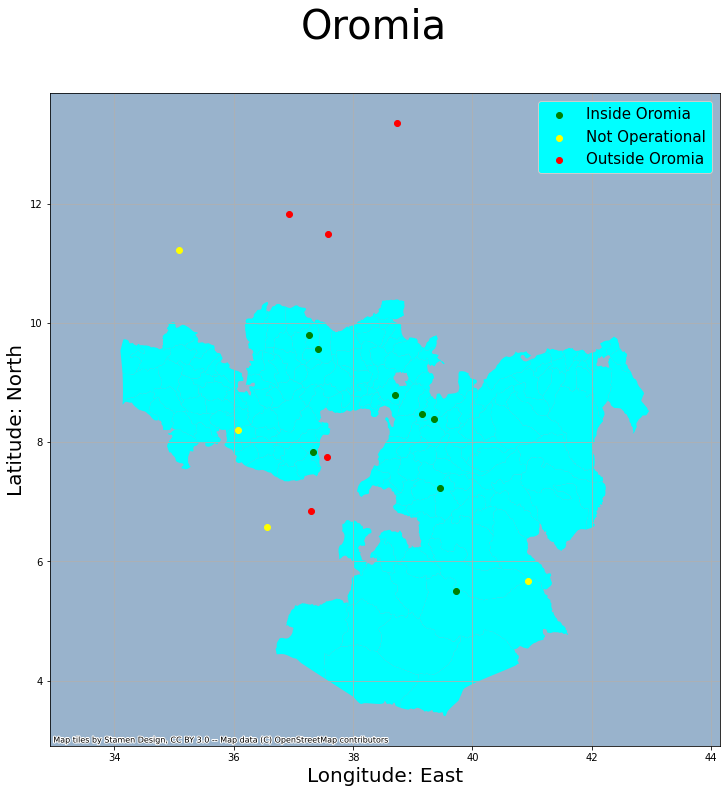

In [9]:
f, ax = plt.subplots(1, figsize=(12, 12))
ax.set_ylabel("Latitude: North", size=20)
ax.set_xlabel("Longitude: East",size=20)
ax = oromia.plot(ax=ax, alpha=1, color="cyan")
#ax = eth_river.plot(ax=ax, alpha=1, color="cyan")
gdf[(gdf['in_oromia'] == True) & (gdf['operational'] == True)].plot(ax=ax, color = 'green', label="Inside Oromia")
gdf[gdf['operational'] == False].plot(ax=ax, color = 'yellow', label="Not Operational")
gdf[(gdf['in_oromia'] == False) & (gdf['operational'] == True)].plot(ax=ax, color = 'red', label="Outside Oromia")
lims = plt.axis('equal')
f.suptitle('Oromia', size=40)
ax.grid()
ctx.add_basemap(ax, zoom=10)
plt.legend(prop={"size":15}, facecolor='cyan', framealpha=1)
plt.show()

## Can we extract the total power production?....YES
## Can we extract the percentage of Ethiopia’s power that would be at risk?...YES

In [10]:
# ALL ETHIOPIAN HYDRO POWER PRODUCTION:
total= gdf['Installedcapacity (MWe)']
total = [float(prod) for prod in total if "(" not in prod]
total_power = sum(total)

# OROMIA HYDRO POWER PRODUCTION:
total_oromia = gdf[gdf['in_oromia']==True]['Installedcapacity (MWe)']
total_oromia = [float(prod) for prod in total_oromia if "(" not in prod]
total_oromia_power = sum(total_oromia)

# Print Outs
print()
print(f'Ethiopia: Total hydro power production = {total_power} MWe')
print(f'Oromia: Total hydro power production = {total_oromia_power} MWe')
perc = round((total_oromia_power/total_power)*100,2)
print(f'Oromia hydro supports {perc}% of Ethiopian hydro power')


Ethiopia: Total hydro power production = 4068.0 MWe
Oromia: Total hydro power production = 933.6 MWe
Oromia hydro supports 22.95% of Ethiopian hydro power


### Which specific facilities would be at risk?

Caveman analysis: 
Let's look at how a drought would affect power production

In [11]:
def no_rain(x, drought_index):
    return x*drought_index

In [12]:
# Back of the napkin model that would require a SME for accurate scaling

#     FILL THIS OUT
drought_index = .8             # factor by which power production is reduced due to drought 
ethiopia_min_capacity = 2500.0 # min power required in MWe


threshold = ethiopia_min_capacity
total_d = gdf['Installedcapacity (MWe)']
all_drought = [float(prod) for prod in total_d if "(" not in prod]
ad = sum([no_rain(x, drought_index) for x in all_drought])
print()
if ad >= threshold:
    print(f'Success: Drought power production of {round(ad,2)} MWe meets {round(threshold,2)} MWe minimum by {round((ad-threshold )/threshold*100,2)}%')
else:
    print(f'Warning: Drought power production of {round(ad,2)} MWe does not meet minimum {round(threshold,2)} MWe by {round((threshold-ad)/threshold*100,2)}%')


Success: Drought power production of 3254.4 MWe meets 2500.0 MWe minimum by 30.18%


### Which specific facilities would be at risk?


Set a SME-based required power threshold in MWe and see what combinations of facilities are required to support the threshold (assuming the plants are operating at full output).

### let's say Oromia needs to provide, at a minimum, 15% of Ethiopia's hydro power...what combinations of plants can support this threshold?

In [13]:
# Get operational plants in Oromia
oromia_hydro = gdf[(gdf['in_oromia'] == True) & (gdf['operational'] == True)]
oromia_hydro = oromia_hydro.reset_index(inplace=False)

In [14]:
# twist the number of plants/combos to see which groupings meet power threshold
def f(min, max, num):    
    return itertools.combinations(range(min, max), num)

def combo_it1(total_plants, num_op_plants, min_power, oromia_hydro):
    
    # iterate of the indicies to get n choose k combos for all plants
    combo_super_list = []
    num_plants = [x for x in range(total_plants+1)]
    for num in num_plants:
        combos = f(0, total_plants, num)
        for combo in combos:
            combo_super_list.append(combo)
            
    # get power production for plants in combo and see if combo meets threshold      
    good_combos = []
    for comb in combo_super_list:
        temp = 0
        for ind in comb:
            temp = temp + float(oromia_hydro['Installedcapacity (MWe)'].loc[ind])
        if temp >= min_power:
            good_news = [comb,temp]
            good_combos.append(good_news)
    
    # map indicies to plant name
    needed_plants = []
    for combo in good_combos: 
        if len(combo[0]) == num_op_plants:
            comb = combo[0]
            temp_p = []
            for ind in comb:
                temp = oromia_hydro['ICS Power plant'].loc[ind]
                temp = temp.split("[")[0]
                #temp = (temp)
                temp_p.append(temp)
                this_is_it = (temp_p, combo[1])   
            needed_plants.append(this_is_it) 

    if needed_plants == []:
        print(f'No combo meets power need of {round(min_power,2)} MWe')
    else:
        print(f'The following plant combinations meet the {round(min_power,2)} MWe requirement:')
        print()
        for plant in needed_plants:
            print(plant)              

In [15]:
#  Enter Data Here
perc = .15        # percentage of hydro power Oromia must meet         
num_op_plants = 4  # choose number of plants to meet the power requirement 

# leave alone...
total_plants = len(oromia_hydro.index)
ethiopia_max_hydro = 4068.0 
min_power = ethiopia_max_hydro * perc

combo_it1(total_plants, num_op_plants, min_power,oromia_hydro)

The following plant combinations meet the 610.2 MWe requirement:

(['Koka (Awash I)', 'Fincha', 'Gilgel Gibe I', 'Genale Dawa III'], 615.0)
(['Koka (Awash I)', 'Gilgel Gibe I', 'Melka Wakena', 'Genale Dawa III'], 634.0)
(['Awash II+III', 'Fincha', 'Gilgel Gibe I', 'Genale Dawa III'], 636.0)
(['Awash II+III', 'Gilgel Gibe I', 'Melka Wakena', 'Genale Dawa III'], 655.0)
(['Fincha', 'Fincha Amerti Neshe (FAN)', 'Gilgel Gibe I', 'Genale Dawa III'], 667.0)
(['Fincha', 'Fincha Amerti Neshe (FAN)', 'Melka Wakena', 'Genale Dawa III'], 636.0)
(['Fincha', 'Gilgel Gibe I', 'Melka Wakena', 'Genale Dawa III'], 725.0)
(['Fincha Amerti Neshe (FAN)', 'Gilgel Gibe I', 'Melka Wakena', 'Genale Dawa III'], 686.0)
